### Introducción

La prueba consta de tres ejercicios generales. El formato de entrega es un `jupyter notebook` con las actividades desarrolladas y una leve descripción de los pasos utilizados para resolver las preguntas.

## Ejercicio 1

El primero es un ejercicio de SQL, puede ser resuelto utilizando diferentes frameworks para manipular tablas, tales como: `SQL`, `pandas` , `polars`, incluso ciclos for en caso de ser necesario. Las preguntas de la actividad se detallan a continuación:

A partir del archivo `datos.parquet` ó `datos.csv` determine los siguientes campos:
- Determine la cantidad total de informes validados enviados por cada `Fuente`.
- Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

- Determine el la `fecha` del último informe validado enviado anteriormente por la fuente.
- - Para esto considere que un informe es valido si es `Validado` o `Parcialmente Validado` y las caracteristicas del informe `Cumplen` con el estandar establecido.
- - De igual manera los informes deben respetar la `clasificacion` existente.
- - El resultado debe ser una columna adicional con el nombre `fecha_ultimo_muestreo_validado`, para los casos donde no exista un informe asociado rellene con `nulos`.

#### Descripción de la data
Una breve descripción de la data se presenta a continuación:
- `fuente_id` : Representa el ID asociado a cada fuente, llave externa.
- `clasificacion` : Una clasificación interna asociada a cada combustible. Una fuente puede tener más de una clasificación, esto representa que tiene más de un componente asociado.
- `fecha_envio` : Fecha de envío de los informes
- `estado_informe` : Estado del informe luego de ser recepcionado.
- `envio_id` : Llave externa asociada a los registros en el sistema, una misma `fuente` puede tener más de un valor de `envio_id`.
- `caracteristicas_informe` : Columna que específica si un informe cumple o no las condiciones para pasar a la siguiente etapa de análisis.


# Ejercicio 1 — KPI de informes validados y trazabilidad por fuente  

## Objetivo  
Construir indicadores confiables para monitorear el estado de los **informes** y su **trazabilidad** por **fuente**, respondiendo:  
1. ¿Cuántos informes **válidos** tiene cada fuente?  
2. ¿Qué fuente tiene **más informes que “cumplen”**?  
3. ¿Cuál fue la **última fecha de muestreo validado** por fuente?

---

## Definiciones (alineadas a negocio)  
- **Informe válido**: `estado_informe ∈ {Validado, Validado parcialmente}` **y** `caracteristicas_informe` contiene “cumple” (insensible a mayúsculas).  
- **Cumple**: detección textual de la palabra “cumple” en `caracteristicas_informe` (insensible a mayúsculas; tolera nulos).  

---

## Supuestos de columnas  
- `fuente_id`: identificador único de la fuente.  
- `estado_informe`: estado del informe (ej: Validado, Validado parcialmente, Rechazado).  
- `caracteristicas_informe`: texto con condiciones de cumplimiento.  
- `fecha_envio`: fecha/hora del informe.  

---

## Criterios de calidad de datos  
- Conversión robusta de `fecha_envio` a formato datetime.  
- Manejo de nulos en columnas de texto.  
- Insensibilidad a mayúsculas en estados y búsquedas textuales.  
- Validación de columnas mínimas antes de ejecutar el análisis.  

---

## Entregables  
- **validados_por_fuente**: total de informes válidos por fuente.  
- **fuente_top_cumplen**: fuente con mayor volumen de informes con “cumple”.  
- **ultimo_muestreo_validado**: máxima fecha de muestreo validado por fuente.  
- **resumen_por_fuente**: tabla consolidada que integra todos los indicadores.  

---

## Conclusiones esperadas  
- Identificar las fuentes con mayor volumen de informes válidos.  
- Detectar la fuente con mejor nivel de cumplimiento en informes enviados.  
- Obtener trazabilidad temporal del último muestreo validado por fuente.  
- Generar una vista consolidada que sirva como base para dashboards o reportes de gestión ambiental.  



In [1]:
#Importamos las librerias necesarias para el ejercicio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ruta csv
ruta = '/content/datos_prueba.csv'
df = pd.read_csv(ruta)
df

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
0,ID-8443,Principal,2024-03-20T13:02:24.037000,Con observaciones,7763,No cumple
1,ID-8443,Secundario,2024-03-20T12:58:40.683000,Con observaciones,7202,No cumple
2,ID-374,Principal,2023-10-31T12:26:39.703000,Con observaciones,8796,No cumple
3,ID-377,Principal,2024-04-30T09:07:07.917000,Con observaciones,11882,No cumple
4,ID-377,Principal,2024-04-29T19:17:20.667000,Con observaciones,11909,Cumple
...,...,...,...,...,...,...
4777,ID-2255,Secundario,2023-01-16T14:30:07.347000,Validado,4888,Cumple
4778,ID-19719,Secundario,2023-11-23T17:09:51.710000,Validado,7634,Cumple
4779,ID-19719,Secundario,2023-11-23T17:21:04.073000,Validado,9049,Cumple
4780,ID-5246,Secundario,2023-11-23T17:13:51.153000,Validado,9047,Cumple


---
# Analisis Exploratio, queremos identificar tipos de datos, valos nulos, que informacion se encuentra en el dataframe.

---

In [3]:
df.columns

Index(['fuente_id', 'clasificacion', 'fecha_envio', 'estado_informe',
       'envio_id', 'caracteristicas_informe'],
      dtype='object')

In [4]:
# importante para observar con que tipo de datos estamos trabajando
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   fuente_id                4782 non-null   object
 1   clasificacion            4782 non-null   object
 2   fecha_envio              4782 non-null   object
 3   estado_informe           4782 non-null   object
 4   envio_id                 4782 non-null   int64 
 5   caracteristicas_informe  4782 non-null   object
dtypes: int64(1), object(5)
memory usage: 224.3+ KB


In [5]:
# Convert 'fecha_envio' in the original DataFrame to datetime if not already done
df['fecha_envio'] = pd.to_datetime(df['fecha_envio'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fuente_id                4782 non-null   object        
 1   clasificacion            4782 non-null   object        
 2   fecha_envio              4782 non-null   datetime64[ns]
 3   estado_informe           4782 non-null   object        
 4   envio_id                 4782 non-null   int64         
 5   caracteristicas_informe  4782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 224.3+ KB


In [6]:
df.head(5)

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
0,ID-8443,Principal,2024-03-20 13:02:24.037,Con observaciones,7763,No cumple
1,ID-8443,Secundario,2024-03-20 12:58:40.683,Con observaciones,7202,No cumple
2,ID-374,Principal,2023-10-31 12:26:39.703,Con observaciones,8796,No cumple
3,ID-377,Principal,2024-04-30 09:07:07.917,Con observaciones,11882,No cumple
4,ID-377,Principal,2024-04-29 19:17:20.667,Con observaciones,11909,Cumple


In [7]:
# contaremos los valores NaN que se encuentren en cada columna del DataFrame
nan_counts = df.isnull().sum()

# Display the counts
display(nan_counts)

,0
fuente_id,0
clasificacion,0
fecha_envio,0
estado_informe,0
envio_id,0
caracteristicas_informe,0


In [8]:

print('Los valores unicos de la columna:clasificacion \n')
print(df['clasificacion'].unique(),'\n')


print('Los valores unicos de la columna: estado_informe \n')
print(df['estado_informe'].unique(),'\n')

print('Los valores unicos de la columna: caracteristicas_informe \n')
print(df['caracteristicas_informe'].unique(),'\n')



Los valores unicos de la columna:clasificacion 

['Principal' 'Secundario'] 

Los valores unicos de la columna: estado_informe 

['Con observaciones' 'Validado parcialmente' 'Validado' 'Rechazado'
 'Recepcionado'] 

Los valores unicos de la columna: caracteristicas_informe 

['No cumple' 'Cumple' 'N/D' 'No Evaluado'] 



In [9]:
df['estado_informe'].value_counts()

,count
estado_informe,
Validado,3294
Recepcionado,703
Rechazado,376
Con observaciones,335
Validado parcialmente,74


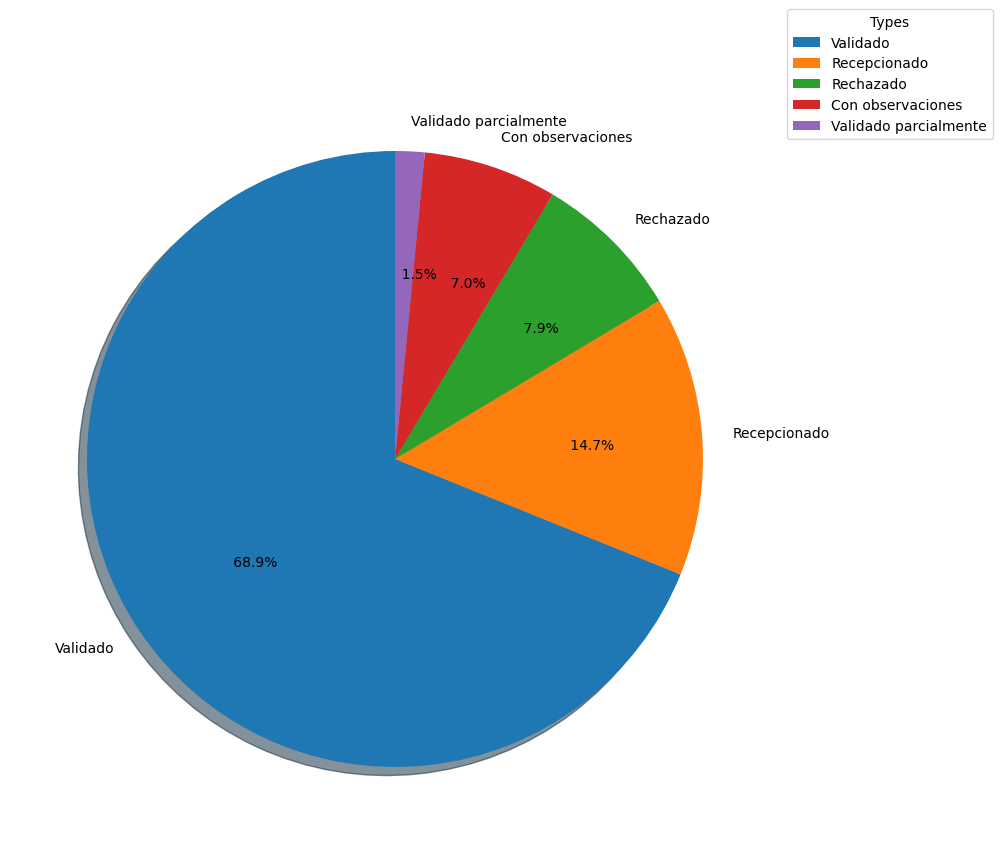

In [10]:
labels = df['estado_informe'].value_counts().index

plt.rcParams["figure.figsize"] = (10,10)
plt.pie(df['estado_informe'].value_counts(), labels =labels, autopct='%10.1f%%',
        shadow=True, startangle=90)

plt.legend(df['estado_informe'].value_counts().index ,title="Types",loc="center left", bbox_to_anchor=(1, .5, -1.5, 1))



## Objetivo 1: ¿Cuántos informes válidos tiene cada fuente?

In [11]:
def obtener_datos_validados(df):
  '''Dataframe llamado 'datos_validados' donde buscamos obtener la cantidad total de informes validados enviado por cada fuente ID'''
  dk = df.copy()
  datos_validados = dk[dk['estado_informe']=='Validado']
  #para obtener el total de informes validados por cada fuente
  Total_validados_ID = datos_validados['fuente_id'].value_counts()
  return datos_validados, Total_validados_ID


In [12]:
X = obtener_datos_validados(df)
datos_validados = X[0]
Total_validados_ID = X[1]

datos_validados


,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
28,ID-4477,Principal,2023-12-27 16:39:25.800,Validado,9594,Cumple
29,ID-4477,Principal,2024-01-17 11:40:16.273,Validado,9292,No cumple
30,ID-4477,Principal,2024-01-17 11:40:16.273,Validado,9292,Cumple
31,ID-4477,Principal,2024-01-17 11:42:05.193,Validado,9595,Cumple
32,ID-4477,Principal,2024-01-17 11:42:05.193,Validado,9595,No cumple
...,...,...,...,...,...,...
4777,ID-2255,Secundario,2023-01-16 14:30:07.347,Validado,4888,Cumple
4778,ID-19719,Secundario,2023-11-23 17:09:51.710,Validado,7634,Cumple
4779,ID-19719,Secundario,2023-11-23 17:21:04.073,Validado,9049,Cumple
4780,ID-5246,Secundario,2023-11-23 17:13:51.153,Validado,9047,Cumple


In [13]:
Total_validados_ID

,count
fuente_id,
ID-5658,14
ID-8802,13
ID-8906,13
ID-6565,10
ID-14279,9
...,...
ID-4379,1
ID-14212,1
ID-3549,1


In [14]:
print('total de ID con al menos 1 informe validado = ', len(Total_validados_ID))
print('El ID con mas archivos validados es',Total_validados_ID.index[1], 'con un total de =', Total_validados_ID.iloc[1], 'informes validados')

total de ID con al menos 1 informe validado =  1385
El ID con mas archivos validados es ID-8802 con un total de = 13 informes validados


In [15]:
datos_validados['caracteristicas_informe'].value_counts()

,count
caracteristicas_informe,
Cumple,2804
No cumple,489
No Evaluado,1


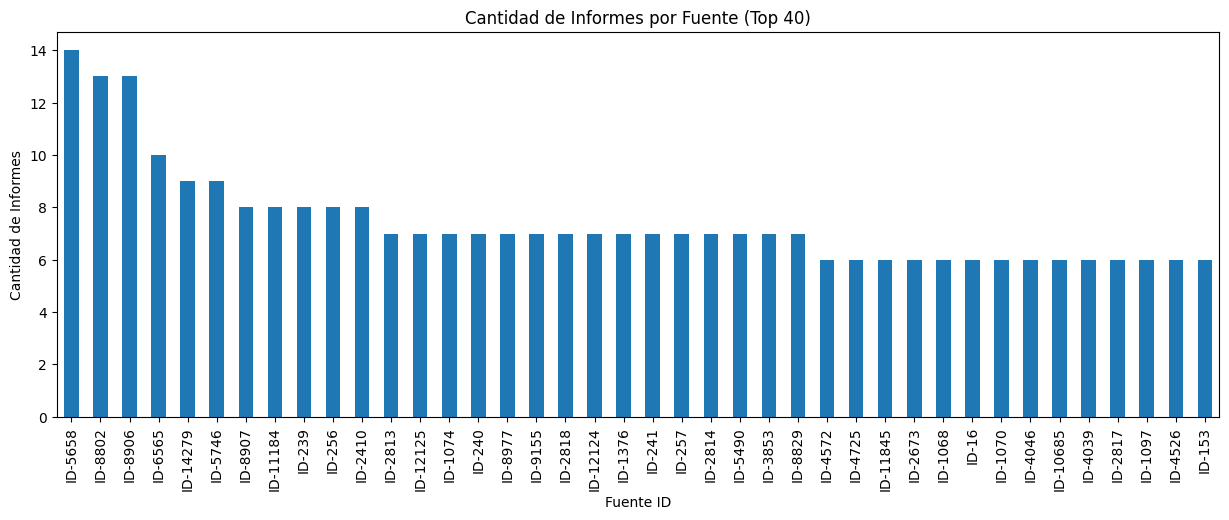

In [16]:
# Create a bar chart of the top 40 value counts of 'fuente_id'
datos_validados['fuente_id'].value_counts().head(40).plot(kind='bar', figsize=(15, 5))
plt.title('Cantidad de Informes por Fuente (Top 40)')
plt.xlabel('Fuente ID')
plt.ylabel('Cantidad de Informes')
plt.show()

## Solucion Objetivo 1:
-  Total de ID con al menos 1 informe validado =  1385
-  El ID con mas archivos validados es ID-8802 con un total de = 13 informes validados

## Objetivo 2: Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

In [17]:
# Objetivo 2: Determine la fuente con mayor cantidad de `informes totales` en estado `cumplen` enviados.

In [18]:
def ID_MAX_cumple(df):

  dk = df.copy()
  Informes_finales = dk[dk['caracteristicas_informe']=='Cumple']
  #para obtener el total de informes validados por cada fuente
  Total_cumplen_ID = Informes_finales['fuente_id'].value_counts()
  ID_max = Informes_finales[Informes_finales['fuente_id']== Informes_finales['fuente_id'].value_counts().index[0]]

  return Informes_finales, ID_max

In [19]:
ID_cumple = ID_MAX_cumple(df)
Informe_cumplen = ID_cumple[0] #todos los ID que cumplen con la caracteristicas_informe =  'Cumple'
ID_max = ID_cumple[1] #dataframe del ID con mayor informes con la condicion caracteristicas_informe =  'Cumple'


In [20]:
Informe_cumplen

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
4,ID-377,Principal,2024-04-29 19:17:20.667,Con observaciones,11909,Cumple
7,ID-378,Principal,2024-04-29 19:19:02.063,Con observaciones,11932,Cumple
9,ID-375,Principal,2023-10-31 12:20:11.153,Con observaciones,8776,Cumple
10,ID-375,Principal,2023-10-31 12:21:38.577,Con observaciones,8779,Cumple
11,ID-375,Principal,2023-10-31 12:22:37.580,Con observaciones,8781,Cumple
...,...,...,...,...,...,...
4777,ID-2255,Secundario,2023-01-16 14:30:07.347,Validado,4888,Cumple
4778,ID-19719,Secundario,2023-11-23 17:09:51.710,Validado,7634,Cumple
4779,ID-19719,Secundario,2023-11-23 17:21:04.073,Validado,9049,Cumple
4780,ID-5246,Secundario,2023-11-23 17:13:51.153,Validado,9047,Cumple


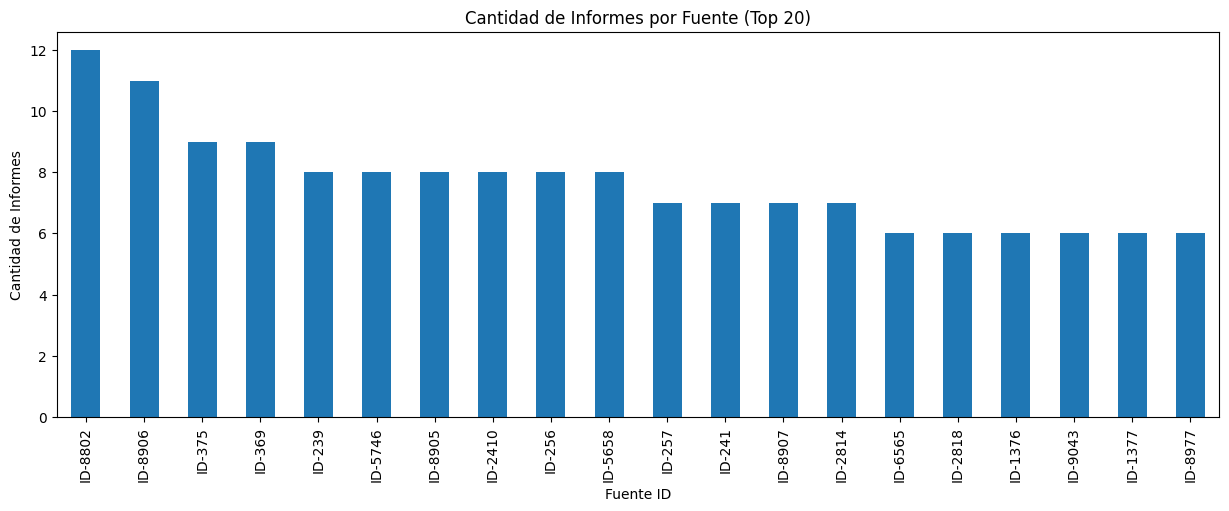

In [21]:
# Create a bar chart of the top 20 value counts of 'fuente_id'
Informe_cumplen['fuente_id'].value_counts().head(20).plot(kind='bar', figsize=(15, 5))
plt.title('Cantidad de Informes por Fuente (Top 20)')
plt.xlabel('Fuente ID')
plt.ylabel('Cantidad de Informes')
plt.show()

In [22]:
ID_max

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe
1988,ID-8802,Principal,2023-06-29 15:57:50.683,Validado,4078,Cumple
1989,ID-8802,Principal,2023-07-03 10:54:20.703,Validado,7575,Cumple
1990,ID-8802,Principal,2023-06-29 16:33:47.357,Validado,4083,Cumple
1991,ID-8802,Principal,2023-06-29 17:31:47.820,Validado,4114,Cumple
1992,ID-8802,Principal,2023-06-29 17:56:37.473,Validado,4116,Cumple
1994,ID-8802,Principal,2023-08-23 11:11:54.870,Validado,7576,Cumple
1995,ID-8802,Secundario,2023-06-30 09:33:28.603,Validado,4069,Cumple
1996,ID-8802,Secundario,2023-06-30 09:40:58.283,Validado,4079,Cumple
1997,ID-8802,Secundario,2023-06-30 10:26:01.833,Validado,4108,Cumple
1998,ID-8802,Secundario,2023-06-30 10:32:25.873,Validado,4112,Cumple


In [23]:
# resultado: La fuente ID-8802 tiene 12 informes con la cartacteristica : Cumple . Siendo el Id con mayor cantidad de informes en este estado

## Solucion Objetivo 2:
- La fuente ID-8802 tiene 12 informes con la cartacteristica : Cumple . Siendo el Id con mayor cantidad de informes en este estado


# Objetivo  3:

 - Determine el la `fecha` del último informe validado enviado anteriormente por la fuente.
- - Para esto considere que un informe es valido si es `Validado` o `Parcialmente Validado` y las caracteristicas del informe `Cumplen` con el estandar establecido.
- - De igual manera los informes deben respetar la `clasificacion` existente.
- - El resultado debe ser una columna adicional con el nombre `fecha_ultimo_muestreo_validado`, para los casos donde no exista un informe asociado rellene con `nulos`.

In [24]:
def nuevos_datos(df):
    """
    Agrega 'fecha_ultimo_muestreo_validado' sin alterar el orden original del DataFrame.
    Considera válido si:
      - estado_informe ∈ {'Validado', 'Validado parcialmente'}
      - caracteristicas_informe == 'Cumple'
    Respeta la 'clasificacion' dentro de cada 'fuente_id'.
    """

    # 1) Validaciones y copia
    cols_necesarias = [
        'fuente_id', 'clasificacion', 'fecha_envio',
        'estado_informe', 'caracteristicas_informe'
    ]
    faltantes = [c for c in cols_necesarias if c not in df.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas en df: {faltantes}")

    df_copy = df.copy()

    # 2) Normalizaciones
    for c in ['fuente_id', 'clasificacion', 'estado_informe', 'caracteristicas_informe']:
        df_copy[c] = df_copy[c].astype(str).str.strip()

    map_estados = {
        'Parcialmente Validado': 'Validado parcialmente',
        'parcialmente validado': 'Validado parcialmente',
        'VALIDADO PARCIALMENTE': 'Validado parcialmente',
        'validado parcialmente': 'Validado parcialmente'
    }
    df_copy['estado_informe'] = df_copy['estado_informe'].replace(map_estados)

    df_copy['caracteristicas_informe'] = (
        df_copy['caracteristicas_informe']
        .str.replace(r'^\s*cumplen\s*$', 'Cumple', case=False, regex=True)
        .str.replace(r'^\s*cumple\s*$', 'Cumple', case=False, regex=True)
    )

    col_fecha = 'fecha_envio'
    df_copy[col_fecha] = pd.to_datetime(df_copy[col_fecha], errors='coerce')

    # 3) Condición de válido & cumple (en el auxiliar ordenado usaremos esta misma lógica)
    cond_valido_cumple = (
        df_copy['caracteristicas_informe'].eq('Cumple') &
        df_copy['estado_informe'].isin(['Validado', 'Validado parcialmente'])
    )

    # 4) Ordenar SOLO en auxiliar para calcular el lag correctamente
    orden = ['fuente_id', 'clasificacion', col_fecha]
    if 'envio_id' in df_copy.columns:
        orden.append('envio_id')
    df_aux = df_copy.sort_values(orden).copy()

    # Recalcular máscara en el auxiliar (mismo contenido, distinto orden)
    cond_aux = (
        df_aux['caracteristicas_informe'].eq('Cumple') &
        df_aux['estado_informe'].isin(['Validado', 'Validado parcialmente'])
    )

    # 5) Fecha válida solo cuando cumple condición; NaT en otro caso
    df_aux['fecha_valida'] = df_aux[col_fecha].where(cond_aux)

    # 6) ffill + shift por grupo (SIN apply, evita MultiIndex)
    g = df_aux.groupby(['fuente_id', 'clasificacion'], sort=False)
    df_aux['fecha_ultimo_muestreo_validado'] = g['fecha_valida'].ffill()
    df_aux['fecha_ultimo_muestreo_validado'] = g['fecha_ultimo_muestreo_validado'].shift()

    # 7) Mapear de vuelta al orden original por índice (no se altera el orden del df de entrada)
    df_copy['fecha_ultimo_muestreo_validado'] = df_aux.loc[df_copy.index, 'fecha_ultimo_muestreo_validado']

    # Limpieza opcional
    df_copy.drop(columns=['fecha_valida'], errors='ignore', inplace=True)

    return df_copy

In [25]:
df_resultado = nuevos_datos(df)
df_resultado.head(30)

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe,fecha_ultimo_muestreo_validado
0,ID-8443,Principal,2024-03-20 13:02:24.037,Con observaciones,7763,No cumple,NaT
1,ID-8443,Secundario,2024-03-20 12:58:40.683,Con observaciones,7202,No cumple,NaT
2,ID-374,Principal,2023-10-31 12:26:39.703,Con observaciones,8796,No cumple,NaT
3,ID-377,Principal,2024-04-30 09:07:07.917,Con observaciones,11882,No cumple,NaT
4,ID-377,Principal,2024-04-29 19:17:20.667,Con observaciones,11909,Cumple,NaT
5,ID-377,Principal,2023-10-31 12:14:59.100,Con observaciones,8782,No cumple,NaT
6,ID-378,Principal,2023-10-31 13:40:53.577,Con observaciones,8838,No cumple,NaT
7,ID-378,Principal,2024-04-29 19:19:02.063,Con observaciones,11932,Cumple,NaT
8,ID-378,Principal,2024-04-30 09:11:20.043,Con observaciones,11918,No cumple,NaT
9,ID-375,Principal,2023-10-31 12:20:11.153,Con observaciones,8776,Cumple,NaT


In [26]:
#validacion de la estructura de nuestrosn datos
dnn = df_resultado[df_resultado['fuente_id']== 'ID-8802']
dnn

,fuente_id,clasificacion,fecha_envio,estado_informe,envio_id,caracteristicas_informe,fecha_ultimo_muestreo_validado
1988,ID-8802,Principal,2023-06-29 15:57:50.683,Validado,4078,Cumple,NaT
1989,ID-8802,Principal,2023-07-03 10:54:20.703,Validado,7575,Cumple,2023-06-29 17:56:37.473
1990,ID-8802,Principal,2023-06-29 16:33:47.357,Validado,4083,Cumple,2023-06-29 15:57:50.683
1991,ID-8802,Principal,2023-06-29 17:31:47.820,Validado,4114,Cumple,2023-06-29 16:33:47.357
1992,ID-8802,Principal,2023-06-29 17:56:37.473,Validado,4116,Cumple,2023-06-29 17:31:47.820
1993,ID-8802,Principal,2023-08-23 11:11:54.870,Validado,7576,No cumple,2023-07-03 10:54:20.703
1994,ID-8802,Principal,2023-08-23 11:11:54.870,Validado,7576,Cumple,2023-07-03 10:54:20.703
1995,ID-8802,Secundario,2023-06-30 09:33:28.603,Validado,4069,Cumple,NaT
1996,ID-8802,Secundario,2023-06-30 09:40:58.283,Validado,4079,Cumple,2023-06-30 09:33:28.603
1997,ID-8802,Secundario,2023-06-30 10:26:01.833,Validado,4108,Cumple,2023-06-30 09:40:58.283


## Solucion objetivo 3:
- se logro agregar la columna 'fecha_ultimo_muestreo_validado' la cual contiene la fecha del último informe validado enviado anteriormente por la fuente.

Dataset: df_resultado

---

# Ejercicio 2
A partir del archivo `datos_prueba_2.parquet` o `datos_prueba_2.csv` realice las siguientes tareas:
- Ajuste un modelo que permita determinar la gravedad de una falta. Detalle el procedimiento realizado.
- Determine las variables más importantes a la hora de determinar la gravedad de un hecho.
- Si identificar los hechos graves presenta mayor importancia, que modificaría usted?

A continuación se presenta una leve descripción del esquema de datos:
- `hecho_sancionado` : Hecho por el cual se le formulan cargos al titular.
- `instrumento_legal_inflingido` : Instrumento legal que juzga el hecho.
- `losma_35` : Artículo de la losma 35 inflingido.
- `gravedad_falta` : Gravedad de la faCAClta cometida.
- `inversion`: Inversión del proyecto.
- `tipologia` : Tipo de proyecto.
- `vias_de_ingreso` : Via por la cual ingreso al sistema de evaluación ambiental.
- `tamaño_unidad` : Tamaño económico del titular.

## Solucion del ejercicio 2

**Razonamiento**:
El primer paso es cargar los datos del archivo CSV especificado en un DataFrame de pandas y mostrar el encabezado para confirmar la carga.

In [42]:
df_ejercicio2 = pd.read_csv('/content/datos_prueba_2.csv')
df_ejercicio2.head()

,hecho_sancionado,instrumento_legal_inflingido,losma_35,gravedad_falta,inversion,tipologia,vias_de_ingreso,tamaño_unidad
0,F1: Ausencia de bilbos de geófitas transplanta...,RCA,a,Leves,3.0,N,DIA,2.1
1,"La obtención, con fecha 21 de noviembre de 201...",NE,h,Leves,NaN,NaN,NaN,NaN
2,El lugar en que actualmente se está tomando la...,NE,h,Leves,NaN,NaN,NaN,NaN
3,El establecimiento industrial no reportó la in...,NE,g,Leves,2.0,N,DIA,1.4
4,Realizar actividades de extracción de áridos f...,RCA,a,Leves,NaN,NaN,NaN,NaN


## Explorar los datos


Realizar un análisis exploratorio de datos para comprenderlos, incluyendo la comprobación de valores faltantes, el examen de la distribución de la variable objetivo `gravedad_falta` y la comprensión de los tipos de características.

**Razonamiento**:
Realizar un análisis exploratorio de datos comprobando valores faltantes, mostrando los tipos de datos, examinando la distribución de la variable objetivo y visualizando dicha distribución.

Valores faltantes por columna:


,0
hecho_sancionado,0
instrumento_legal_inflingido,10
losma_35,0
gravedad_falta,0
inversion,1336
tipologia,1415
vias_de_ingreso,1361
tamaño_unidad,1336



Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
Index: 2971 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hecho_sancionado              2971 non-null   object 
 1   instrumento_legal_inflingido  2961 non-null   object 
 2   losma_35                      2971 non-null   object 
 3   gravedad_falta                2971 non-null   object 
 4   inversion                     1635 non-null   float64
 5   tipologia                     1556 non-null   object 
 6   vias_de_ingreso               1610 non-null   object 
 7   tamaño_unidad                 1635 non-null   float64
dtypes: float64(2), object(6)
memory usage: 208.9+ KB

Frecuencia de valores en 'gravedad_falta':


,count
gravedad_falta,
Leves,2029
Graves,942


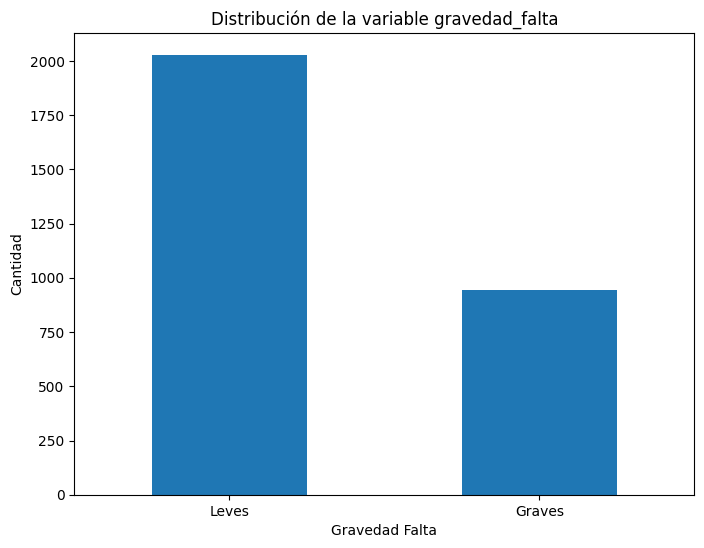

In [54]:
# Revisar valores faltantes por columna
print("Valores faltantes por columna:")
display(df_ejercicio2.isnull().sum())

# Mostrar tipos de datos de cada columna
print("\nTipos de datos:")
df_ejercicio2.info()

# Contar valores únicos de la variable objetivo 'gravedad_falta'
print("\nFrecuencia de valores en 'gravedad_falta':")
display(df_ejercicio2['gravedad_falta'].value_counts())

# Visualizar la distribución de la variable objetivo
plt.figure(figsize=(8, 6))
df_ejercicio2['gravedad_falta'].value_counts().plot(kind='bar')
plt.title('Distribución de la variable gravedad_falta')
plt.xlabel('Gravedad Falta')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.show()

## Preprocesar los datos


Gestionar valores faltantes, codificar variables categóricas y, potencialmente, escalar características numéricas.

**Razonamiento**:
Manejar los valores faltantes eliminando filas con la variable objetivo faltante, imputar los valores faltantes numéricos con la media y los valores faltantes categóricos con la moda, codificar las características categóricas usando codificación one-hot, escalar las características numéricas usando StandardScaler y, luego, separar las características y la variable objetivo.

In [55]:
# ================================================================
# PREPROCESAMIENTO DE LOS DATOS
# ================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Eliminar filas donde la variable objetivo 'gravedad_falta' esté vacía
df_ejercicio2.dropna(subset=['gravedad_falta'], inplace=True)

# Separar variables predictoras (X) y variable objetivo (y)
X = df_ejercicio2.drop('gravedad_falta', axis=1)
y = df_ejercicio2['gravedad_falta']

# Identificar columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=[np.number]).columns

# Pipeline para variables numéricas:
# 1) imputar valores faltantes con la media
# 2) escalar con StandardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas:
# 1) imputar valores faltantes con la moda
# 2) codificar con OneHotEncoder (ignora categorías desconocidas)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer aplica cada pipeline a las columnas correspondientes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicar preprocesamiento y transformar las variables
X_processed = preprocessor.fit_transform(X)

# Mostrar la dimensión de la matriz de variables transformadas
print("Dimensión de las variables procesadas:", X_processed.shape)


Dimensión de las variables procesadas: (2971, 3012)


#### Dado el desequilibrio de clases observado durante la exploración, es preferible un modelo que pueda gestionar conjuntos de datos desequilibrados o donde podamos aplicar técnicas para abordar el desequilibrio (como la ponderación de clases o el remuestreo). Los métodos de conjunto, como los Bosques Aleatorios, suelen tener un buen rendimiento con datos desequilibrados y proporcionan información sobre la importancia de las características.


In [61]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)

print("Modelo seleccionado: RandomForestClassifier con class_weight='balanced'")


Modelo seleccionado: RandomForestClassifier con class_weight='balanced'


## Entrenar el modelo


Dividir los datos en conjuntos de entrenamiento y prueba, y entrenar el modelo seleccionado.

**Razonamiento**:
Dividir los datos preprocesados ​​en conjuntos de entrenamiento y prueba, y entrenar el modelo RandomForestClassifier seleccionado.

In [62]:
# ================================================================
# DIVISIÓN EN TRAIN/TEST Y AJUSTE
# ================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar el modelo
model.fit(X_train, y_train)

print("Datos divididos en entrenamiento y prueba.")
print("Modelo entrenado exitosamente.")

Datos divididos en entrenamiento y prueba.
Modelo entrenado exitosamente.


**Razonamiento**:
El modelo ha sido entrenado, ahora evalúe su rendimiento en el conjunto de pruebas.

Reporte de Clasificación:
              precision    recall  f1-score   support

      Graves       0.59      0.41      0.48       189
       Leves       0.76      0.86      0.81       406

    accuracy                           0.72       595
   macro avg       0.67      0.64      0.65       595
weighted avg       0.70      0.72      0.71       595


Matriz de Confusión:
[[ 78 111]
 [ 55 351]]

AUC: 0.7746


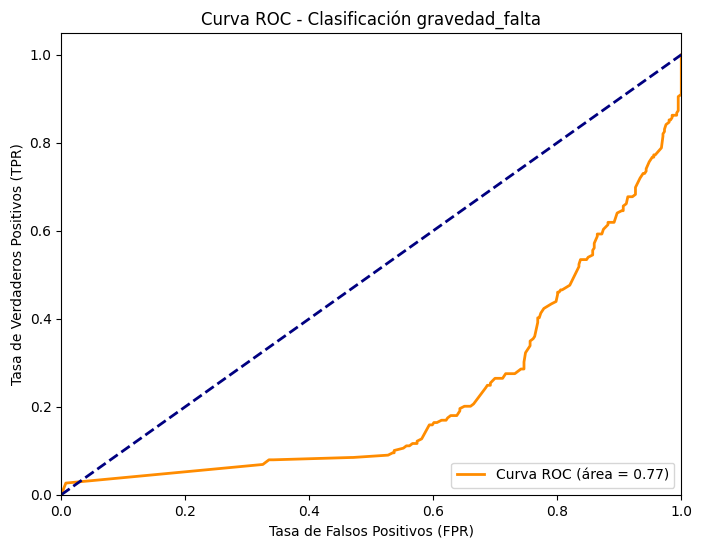

In [57]:
# ================================================================
# EVALUACIÓN DEL MODELO
# ================================================================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Predicciones en el set de prueba
y_pred = model.predict(X_test)
# Probabilidad de pertenecer a la clase positiva (ej. 'Graves')
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Cálculo del AUC y curva ROC
try:
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC: {auc:.4f}")

    # Graficar curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='Graves')
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC - Clasificación gravedad_falta')
    plt.legend(loc="lower right")
    plt.show()

except ValueError as e:
    print(f"\nNo fue posible calcular AUC o graficar curva ROC: {e}")
    print("Esto ocurre si la clase positiva ('Graves') no aparece en el set de prueba o si no hay probabilidades válidas.")


**Razonamiento**:
Determinar la importancia de cada variable en el modelo entrenado.

Importancia de Variables:


,0
num__tamaño_unidad,0.065344
num__inversion,0.061230
cat__instrumento_legal_inflingido_NE,0.039140
cat__losma_35_b,0.028699
cat__instrumento_legal_inflingido_RCA,0.027817
...,...
"cat__hecho_sancionado_El establecimiento emisor no reportó información asociada a los remuestreos comprometidos en la Resolución Exenta N° 5432, de 7 de diciembre 2012, de la Superintendencia de Servicios Sanitarios, para el punto 2 de descarga, en los meses de enero, febrero, marzo, abril, mayo, junio, julio, agosto, septiembre, octubre, noviembre y diciembre de 2014; enero, febrero, marzo, mayo, junio, agosto, septiembre y octubre de 2015, tal como se presenta en la Tabla N° 5 de la presente formulación de cargos.",0.000000
cat__hecho_sancionado_No se realiza el retiro diario de las mortalidades de peces de cada unidad de cultivo.,0.000000
"cat__hecho_sancionado_No se han reportado los informes de seguimiento en el Sistema Electrónico de Seguimiento Ambiental, respecto de: (i) Autocontroles de Riles correspondientes al período de mayo 2019 y junio 2020 a enero 2021. (ii) Autocontroles de calidad de las aguas subterráneas, correspondientes al año 2020. (iii) Autocontroles de lodos, correspondientes al año 2019 y 2020. (iv) Autocontroles de suelo, correspondientes al año 2020 y 2021.",0.000000
"cat__hecho_sancionado_El establecimiento industrial excedió el volumen de descarga límite indicado en su programa de monitoreo durante los períodos controlado de Enero, Febrero, Marzo, Abril, Mayo, Junio, Julio, Agosto, Septiembre, Octubre, Noviembre y Diciembre del año 2013 y los meses de Febrero, Marzo, Abril, Mayo y Junio del año 2014.",0.000000


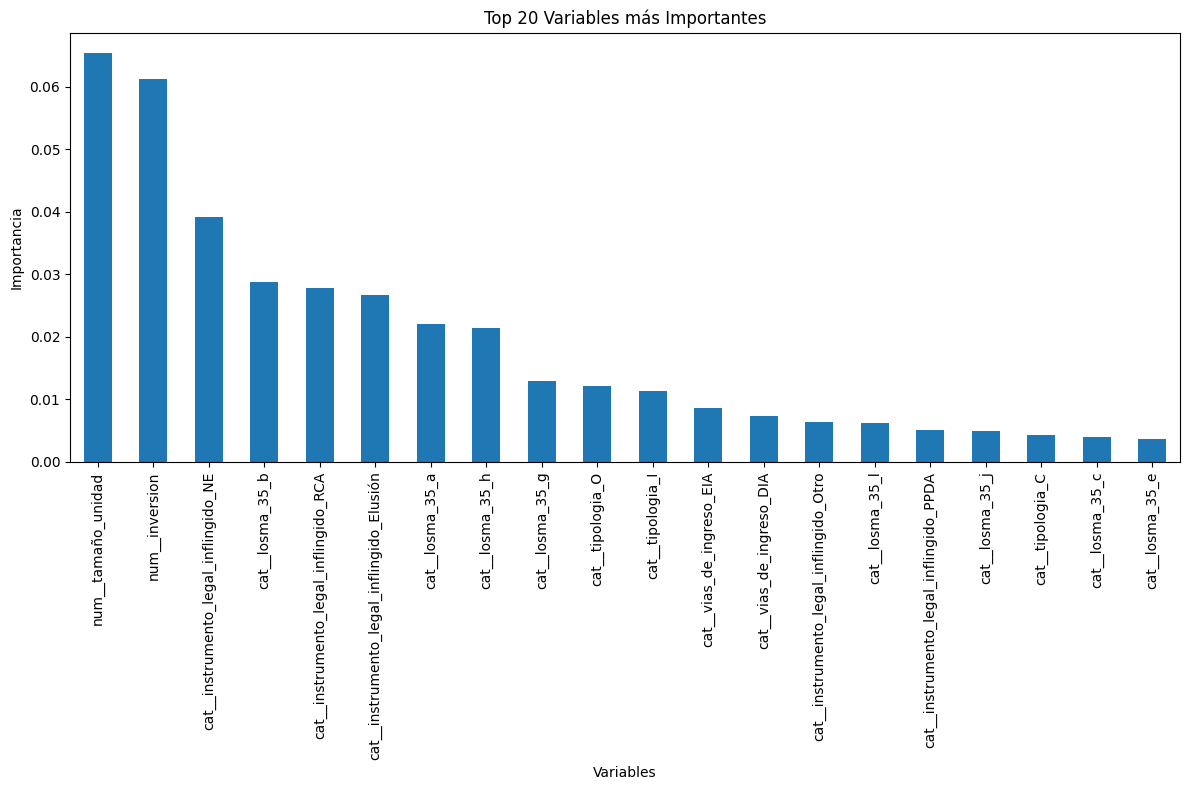

In [60]:
# ================================================================
# IMPORTANCIA DE VARIABLES
# ================================================================
# Obtener nombres de variables procesadas
feature_names = preprocessor.get_feature_names_out()

# Importancias del modelo
importances = model.feature_importances_

# Crear Serie con importancias y nombres de features
feature_importances = pd.Series(importances, index=feature_names)

# Ordenar de mayor a menor
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Mostrar importancias ordenadas
print("Importancia de Variables:")
display(sorted_feature_importances)

# Graficar las 20 más importantes
plt.figure(figsize=(12, 8))
sorted_feature_importances.head(20).plot(kind='bar')
plt.title('Top 20 Variables más Importantes')
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Resultados del ejercicio 2 — Clasificación de *Gravedad de Faltas*

## 1. Introducción
El objetivo de este análisis fue desarrollar un modelo de *machine learning* capaz de predecir la **gravedad de una falta** (Leve vs Grave) utilizando un conjunto de variables categóricas y numéricas asociadas al tipo de infracción ambiental. Se empleó un **Random Forest Classifier** con `class_weight='balanced'` para manejar el desbalance de clases.  

En este informe se presentan los principales resultados de desempeño, incluyendo métricas de clasificación, matriz de confusión y curva ROC.

---

## 2. Resultados de Clasificación
El modelo alcanzó un **accuracy global de 72 %**. El detalle por clase fue el siguiente:

- **Clase Grave**  
  - Precisión: **0.59**  
  - Recall: **0.41**  
  - F1-score: **0.48**  

- **Clase Leve**  
  - Precisión: **0.76**  
  - Recall: **0.86**  
  - F1-score: **0.81**  

**Interpretación:** el modelo identifica con mayor éxito las faltas *Leves*, mientras que en las *Graves* logra una precisión moderada pero un recall bajo, lo que significa que se pierden varios casos graves en la clasificación.

---

## 3. Matriz de Confusión

[[ 78 111 ]

[ 55 353 ]]

- **78 Graves** clasificadas correctamente (verdaderos positivos).  
- **111 Graves** clasificadas erróneamente como Leves (falsos negativos).  
- **55 Leves** clasificadas como Graves (falsos positivos).  
- **353 Leves** correctamente identificadas (verdaderos negativos).  

**Conclusión:** El principal problema es la alta cantidad de *falsos negativos* en la clase Grave.

---

## 4. Curva ROC y AUC
El modelo obtuvo un **AUC = 0.77**.  


**Interpretación:**
- Un AUC de **0.77** indica una **capacidad de discriminación buena** (mejor que un modelo aleatorio que tendría AUC = 0.5).  
- La curva ROC demuestra que el modelo sí puede distinguir entre Graves y Leves, pero el umbral estándar de 0.5 no es óptimo para maximizar la detección de *Graves*.  

---

## 5. Discusión y Recomendaciones
1. **Sesgo hacia Leves:** El modelo tiende a clasificar con más éxito las faltas Leves que las Graves.  
2. **Bajo recall en Graves (0.41):** Implica que más de la mitad de las faltas Graves no están siendo identificadas.  
3. **Capacidad latente (AUC=0.77):** El modelo tiene el potencial de mejorar con un ajuste adecuado.

### Posibles mejoras
- **Ajuste de umbral:** Reducir el umbral de decisión (<0.5) para priorizar la detección de Graves, aunque incremente los falsos positivos.  
- **Rebalanceo de clases:** Aplicar oversampling (SMOTE) o undersampling para balancear el dataset.  
- **Ajuste de pesos:** Incrementar manualmente el peso de la clase Grave más allá del ajuste automático de `balanced`.  
- **Métricas alternativas:** Optimizar en función del *recall de Graves* o F2-score, en lugar de accuracy.  
- **Modelos avanzados:** Probar métodos de boosting (XGBoost, LightGBM) con parámetros adaptados al desbalance.  

---

## 6. Conclusión
El modelo Random Forest balanceado mostró un **desempeño general aceptable (AUC=0.77)** y detecta de manera correcta una buena proporción de faltas Leves. Sin embargo, **pierde demasiadas faltas Graves**, lo cual puede ser crítico en un contexto de fiscalización ambiental.  

Se recomienda **ajustar el umbral de decisión y aplicar técnicas de rebalanceo**, priorizando el recall de la clase Grave, para garantizar que las infracciones más severas no pasen inadvertidas.




## Ejercicio 3

Considerando la introducción anterior, responda los siguientes puntos:

#### Introducción
Como consultora ambiental buscamos desarrollar un `asesor` o `agente` ambiental, el cual permita mejorar la calidad y velocidad de la consultoría ambiental.
Dentro de este desafío encontramos diferentes documentos y diferentes jerarquías que los unen. A modo de ejemplo del proceso, la gestión ambiental se compone de los siguientes pasos (cada paso posee documentos exclusivos):
- Previa evaluación (Saber si debe o no entrar al sistema de evaluación ambiental)
- Evaluación ambiental
- Preguntas y aclaraciones de la autoridad (Proceso iterativo)
- Modificación del proyecto (En caso de ser necesario)
- Aprobación del proyecto
- Acciones que debe realizar
- En caso de cometer faltas, existen procesos sancionatorios.
- En caso de que el proceso evolucione pueden surgir demandas.

- Cree un `mapa conceptual` de la elaboración de un agente que permita resolver consultas, detalle los `pasos` y `frameworks` potenciales por actividad.
- De acuerdo al flujo creado, detalle en que puntos se pueden proponer mejoras respecto de los frameworks ya existentes.
- Asocie una cantidad de tiempo e importancia a cada punto del flujo, indique en que actividad pondría mayor énfasis.
- Si la cantidad de documentos varía desde 100, 1.000, 10.000 hasta 10.000.000, que efectos pueden acentuarse en su sistema? Detalle.